# DETECTING GRAVITATIONAL WAVES WITH MATCHED FILTERING

This notebook gives an example of how to detect a gravitational wave signal in detector data - when we try to detect gravitational waves we are interested in getting a coarse estimate of the intrinsic and extrinsic of the system, but the most important parameters we can measure with a 'detection pipeline' are the strength of the signal (signal-to-noise ratio), how 'signal-like' our detection is (to allow us to reject noise transients) and the time of coalescense. 



These can allow us to then perform more detailed parameter estimation - identifying the location on the sky the signal originated, and the intrinsic properties of the system that produced the gravitational wave. The intrinsic properties can be roughly estimated from the output of the detection pipeline, but this is only a first-guess.


The best way to find any known signal in (Gaussian) noise is with **matched filtering**. There are several different algorithms that do matched filtering to find gravitational waves, but the best library is [PyCBC](https://pycbc.org/) 



This notebook gives an example of how to use PyCBC to find a signal hidden in LIGO detector noise. 


These examples should help you to solve the problems we have set you! Feel free to copy and edit any of this code as you see fit to solve the problems we have given you!

In [2]:
# import the packages we need - we will import these all at the start
import os
import numpy as np
import matplotlib.pyplot as plt

import pycbc.psd
import pycbc.filter
import pycbc.waveform
from pycbc.types import TimeSeries, load_timeseries

# this just gets the address of the current directory to save some typing later
CWD = os.getcwd()

First we need to import some data that has a gravitational wave signal in it. 

This is loaded as a PyCBC [TimeSeries](https://pycbc.org/pycbc/latest/html/pycbc.types.html) - you can load it just as a numpy array, but we will try and stick within the PyCBC workflow as it is quite convenient to use, and has extremely good documentation to explain what it is doing. 

In [3]:
# directory where the data is stored
DATA_DIR = os.path.join(CWD, 'DATA')


# let's see what files are available:
print(os.listdir(DATA_DIR))

['example_timeseries_L1.txt', 'out_logfile_example.csv', 'example_timeseries_H1.txt']


We can load any text file (or hdf5/gwf file for that matter) that is saved in the format ```np.column_stack([sample_times, strain])``` or equivalent directly into a PyCBC Timeseries object

In [7]:
# We are going to load the example file
# L1 is always data from the Livingston detector (H1 = Hanford)
L1_timeseries = load_timeseries(DATA_DIR+'/example_timeseries_L1.txt')

Let's find out what GW detector data looks like!

we can access the times at which the strain is sampled using the 'sample_times'
property of the [TimeSeries](https://pycbc.org/pycbc/latest/html/_modules/pycbc/types/timeseries.html)

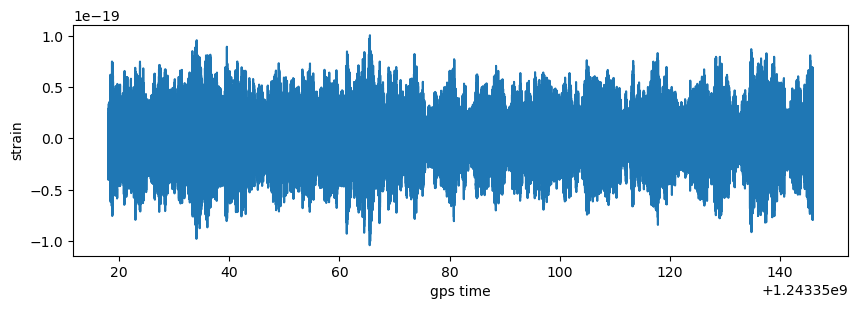

In [8]:
plt.figure(figsize = (10, 3))
plt.plot(L1_timeseries.sample_times, L1_timeseries, 'tab:blue', 
                                                    label = 'L1 (Livingston)')
plt.xlabel('gps time') # LIGO uses GPS times
plt.ylabel('strain')
plt.show()

Ok, so far so good, but this isn't really all that useful - if I told you there was a GW signal hidden in here, 
you probably wouldn't believe me!


In order to start doing matched filtering, we need to 'condition' the data. 



LIGO data is very noisy at low frequencies (<20 Hz), where there is a lot of seismic noise. We can get rid of these frequencies by applying a ['highpass'](https://en.wikipedia.org/wiki/High-pass_filter) filter. We can set it so it only allows through frequencies above 20 Hz.

The PyCBC module has a nice inbuilt highpass filter specifically, it is a Butterworth filter, which comes with it's own quirk you'll see in a second!). You could also create your own highpass filter if you really wanted to, but we'll just use PyCBC!

The second argument in ```pycbc.filter.highpass()``` sets the cut off frequency for the filter. Let's set ours to 20 Hz:

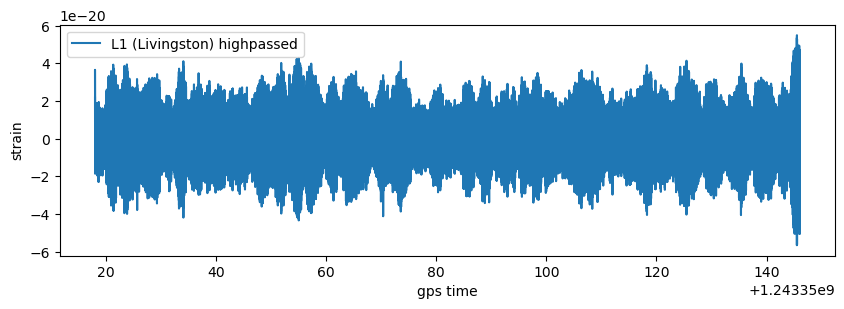

In [9]:
L1_timeseries_conditioned = pycbc.filter.highpass(L1_timeseries, 20.0)

plt.figure(figsize = (10, 3))
plt.plot(L1_timeseries_conditioned.sample_times,L1_timeseries_conditioned, 'tab:blue', 
                                    label = 'L1 (Livingston) highpassed')
plt.xlabel('gps time') # LIGO uses GPS times
plt.ylabel('strain')
plt.legend(loc = 'best')
plt.show()

This looks better - the average max/min strain is an order of magnitude smaller. But something weird is happening at the very end!

Mathematically, the highpass filter assumes that our timeseries is infinite. This is also the case if you're doing anything that involves any kind of filter, including Fourier transformations. This assumption causes ringing at the very edges of our data segment. These can be easily mistaken for some sort of gravitational wave if we are not careful. 

Lots of digital and analog filters also reflect different frequencies back into our timeseries at much lower amplitude. This is called the [Gibbs Phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon). Again, if we're unlucky, this can look an awful lot like a gravitational wave and will confuse our matched filter! This is much more common with lowpass filters (which do the opposite to highpass filters).


To suppress the ringing at the ends of our timeseries, and any reflected frequencies, we will apply something called a [Tukey window](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.windows.tukey.html).

An alternative option is to just hack off the ends of the timeseries using the ```TimeSeries.crop(start_truncation, end_truncation)``` but it's better practice to implement a Tukey window if you can be bothered! 

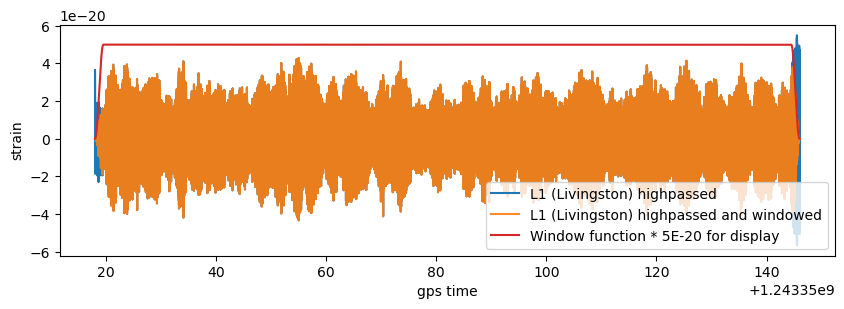

In [11]:
from scipy.signal import tukey

tukey_rolloff = 3.0 # number of seconds to taper by 

window = tukey(len(L1_timeseries_conditioned), tukey_rolloff / (max(L1_timeseries_conditioned.sample_times) \
                                                                - min(L1_timeseries_conditioned.sample_times)))

# actually apply the window! This step sometimes gets forgotten!
L1_timeseries_conditioned_windowed = window * L1_timeseries_conditioned 


# let's see the difference!
plt.figure(figsize = (10, 3))
plt.plot(L1_timeseries_conditioned.sample_times,L1_timeseries_conditioned, 'tab:blue', 
                                    label = 'L1 (Livingston) highpassed')

plt.plot(L1_timeseries_conditioned_windowed.sample_times,
            L1_timeseries_conditioned_windowed, 'tab:orange', 
        label = 'L1 (Livingston) highpassed and windowed', alpha = 0.9)

plt.plot(L1_timeseries_conditioned_windowed.sample_times,
            window*5E-20, 'tab:red', 
        label = 'Window function * 5E-20 for display')

plt.legend(loc = 'best')
plt.xlabel('gps time') # LIGO uses GPS times
plt.ylabel('strain')
plt.show()

Now we have our conditioned strain, we can start searching for our gravitational
wave! 

So far we have our conditioned data. However, the matched filter to search for gravitational waves only works if our data is 'whitened' (the power in each 
frequency bin is the same). This means we need to calculate the power spectral density (PSD) of our data segment. 

PyCBC is great because if we tell it the PSD of the data, it will whiten it for us while filtering! In most implementations, there are special 'pre-whitening' filters that are applied to both our data and templates to speed up our calculations (for example, [this work](https://ui.adsabs.harvard.edu/abs/2018PhRvD..97j3009T/abstract) creates a time-domain whitening filter and also discusses the problem with our simple assumptions we will make here), but for our situation we can just assume that 'whitening' means dividing our frequency-domain data by the PSD.

So, let's calculate the PSD!

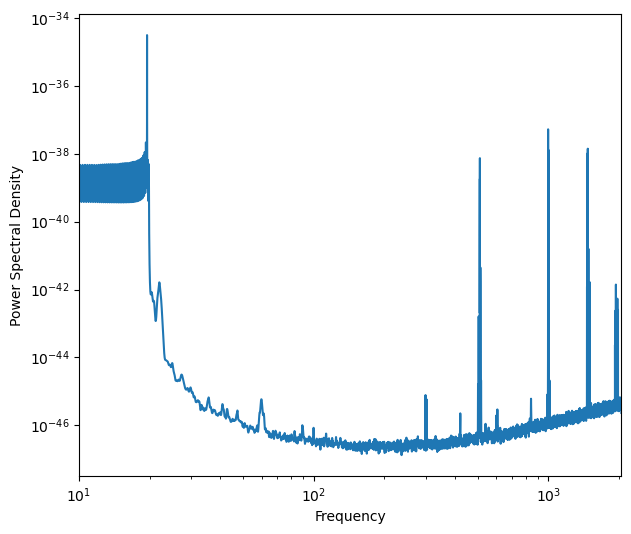

In [12]:
# A common choice is to use the Welch method and to calculate
# the MEDIAN PSD of overlapping
# 4-second segments in our timeseries
segment_length_seconds = 4

# needs to be provided in terms of samples!
seg_len = int(segment_length_seconds / L1_timeseries_conditioned_windowed.delta_t)

# How much to overlap by
seg_stride = int(seg_len / 2)

# Estimate the PSD!
estimated_psd_L1 = pycbc.psd.welch(L1_timeseries_conditioned_windowed,
                      seg_len=seg_len,
                      seg_stride=seg_stride)


# We need to make sure this has the same frequency spacing as our timeseries, 
# so we interpolate
estimated_psd_L1 = pycbc.psd.interpolate(estimated_psd_L1, L1_timeseries_conditioned_windowed.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds.

# Since the data has been highpassed above 20 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 

# We also use something called 'inverse spectrum truncation' - GW detector PSDs have very sharp 
# spikes - if we divide by these, then we will get a lot of very interesting behavior, so 
# this 'softens' those spikes. The concept of 'dividing by a PSD' is actually a very 
# strange one! 

estimated_psd_L1 = pycbc.psd.inverse_spectrum_truncation(estimated_psd_L1,
                                int(4 * L1_timeseries_conditioned_windowed.sample_rate),
                                  low_frequency_cutoff=20.)


# and let's plot it and look at our PSD! 
plt.figure(figsize = (7, 6))
plt.plot(estimated_psd_L1.sample_frequencies, estimated_psd_L1, 'tab:blue', 
                                                label = 'L1 PSD for this segment')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.xlim([10, 2050])
plt.show()

Now we have everything we need to start our matched filtering, except a filter!

Technically we can create a matched filter out of any arbitrary function
but let's try this out with a real gravitational wave!

PyCBC has lots of options to create filters - you can choose different
waveform approximants, and set all kinds of different parameters. We will use the [```pycbc.waveform.get_td_waveform``` ](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html) package to create our filter. 

In general for matched filtering, we would create a template bank with filters of many different combinations of mass1 and mass2, each assigned a uniformly distributed random spin in the z-direction. The spacing of these template banks and how we pick the best 'match' from our SNR timeseries is an interesting mathematical problem. However for an example, we'll just create one template:


In [13]:
# This is just one example of a waveform approximant that's commonly used and covers a wide range of masses
apx = "IMRPhenomD"

# pick some masses for our two components - let's just 'guess' that our
# binary black hole had equal masses, and both masses are 30 Msun
mass = 30.0

# remember that our complex filter output will have the cross polarization 
# encoded in the imaginary component - for this reason
# we only need to bother generating our plus polarisation!
hp, _ = pycbc.waveform.get_td_waveform(approximant=apx, mass1=mass, mass2=mass,
                         f_lower=30.0, 
                        delta_t=L1_timeseries_conditioned_windowed.delta_t)


# remember we need to resize it to the length of our timeseries
hp.resize(len(L1_timeseries_conditioned_windowed))

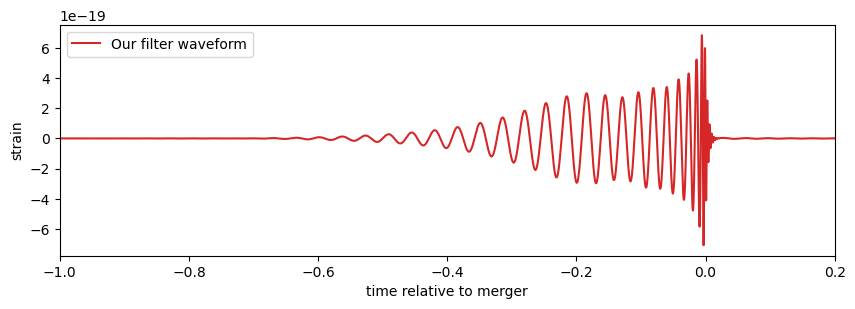

In [14]:
# we can have a look at our waveform! Looking good!

plt.figure(figsize = (10, 3))
plt.plot(hp.sample_times, hp, 'tab:red', 
        label = 'Our filter waveform')
plt.xlim([-1, 0.2])
plt.legend(loc = 'best')
plt.xlabel('time relative to merger') # LIGO uses GPS times
plt.ylabel('strain')
plt.show()

The waveform begins at the start of the vector, so if we want the
SNR time series to correspond to the approximate merger location
we need to shift the data so that the merger is approximately at the 
first bin of the data.

The cyclic_time_shift method shifts the timeseries by a given amount of time.
It treats the data as if it were on a ring buffer, so points shifted off the end
of the series reappear at the start. Note that time stamps are *not* in
general affected (as the start time of the full array is shifted),
but the index of each point in the vector is.

In [16]:
template = hp.cyclic_time_shift(hp.start_time)

It's time!! Let's go!

Remember, technically we should be filtering the whitened data. 

We don't bother to whiten here because PyCBC will do it for us in it's [matched filter](https://pycbc.org/pycbc/latest/html/pycbc.filter.html) function!

In [17]:
# cutting off the integration at 30 Hz means we don't need to worry about those weird
# oscillations that come from the inverse spectrum truncation

L1_snr = pycbc.filter.matched_filter(template, L1_timeseries_conditioned_windowed,
                     psd=estimated_psd_L1, low_frequency_cutoff=30.0)

Remove time corrupted by the template filter and the psd filter
We remove 4 seonds at the beginning and end for the PSD filtering
And we remove 4 additional seconds at the beginning to account for
the template length (this is somewhat generous for 
so short a template). A longer signal such as from a BNS, would 
require much more padding at the beginning of the vector.

Obviously we should really use a Tukey window, but let's be lazy this time and try out the ```crop``` option

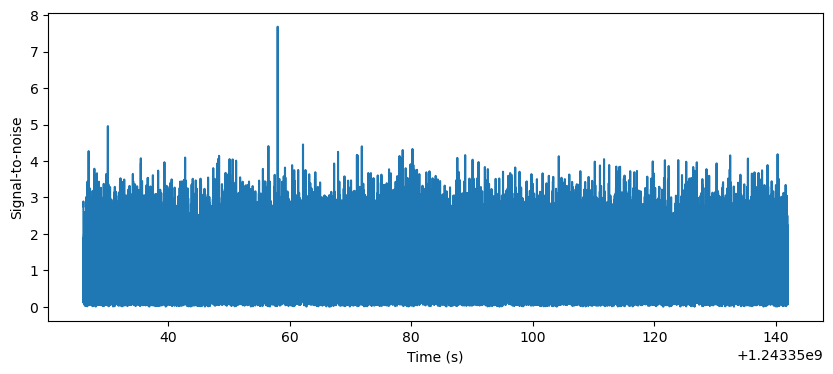

In [229]:
L1_snr = L1_snr.crop(4 + 4, 4)

plt.figure(figsize=[10, 4])
plt.plot(L1_snr.sample_times, abs(L1_snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.show()

Why are we taking an abs() here?

The `matched_filter` function actually returns a 'complex' SNR.
What that means is that the real portion correponds to the SNR
associated with directly filtering the template with the data.

The imaginary portion corresponds to filtering with a template that
is 90 degrees out of phase (i.e. the x component). 

Since the phase of a signal may be 
anything, we choose to maximize over the phase of the signal.

The SNR of this signal is 7.68430199205705
The merger time of this signal is 1243350057.9899902


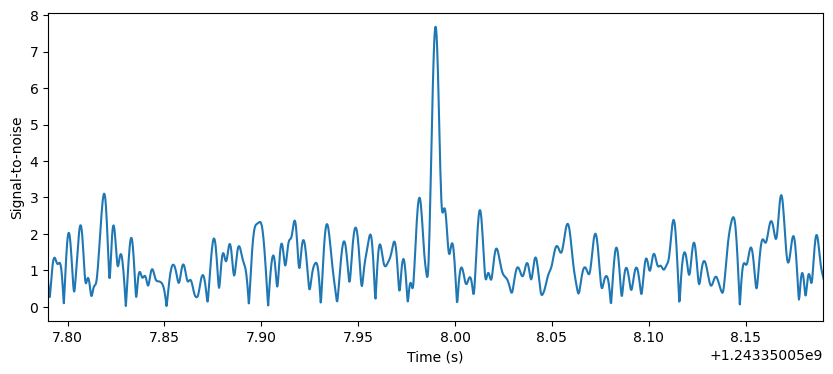

In [18]:
# Wow! Look at that signal! Who would have though it was there!
# let's calculate the SNR of our signal:
this_snr = max(np.abs(L1_snr))
print('The SNR of this signal is {}'.format(this_snr))
merger_time = L1_snr.sample_times[np.argmax(np.abs(L1_snr))]
print('The merger time of this signal is {}'.format(merger_time))

# zoom in close to the merger time! 
plt.figure(figsize=[10, 4])
plt.plot(L1_snr.sample_times, abs(L1_snr))
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.xlim(merger_time - 0.2, merger_time + 0.2)
plt.show()

Not bad for a first try! 

But how do we know that our template is a good match to our data? 
what if there is some kind of mismatch? 

To see how well our data fits our signal, we can use the [Allen time-frequency discriminator](https://ui.adsabs.harvard.edu/abs/2005PhRvD..71f2001A/abstract). 

This uses the properties we assume we know about our noise processes: our noise in Gaussian (no time correllations) and it has been whitened. So statistically we expect our SNRs to be Gaussian distributed with a mean SNR = 0, with a variance of 1. If we think we have a signal and we want to distinguish it from noise, we can then use calculate the reduced $\chi^2$ to see if our hypothesis - that this signal comes from our noise distribution alone - can be rejected.

The ```power_chisq``` function effectively splits our signal up into frequency bins so that equal power from the signal is accumulated into each frequency bin, in the correct order. This allows us to determine whether there is some other loud glitch that saturates our filter, or whether it is ringing up because something matched it well!

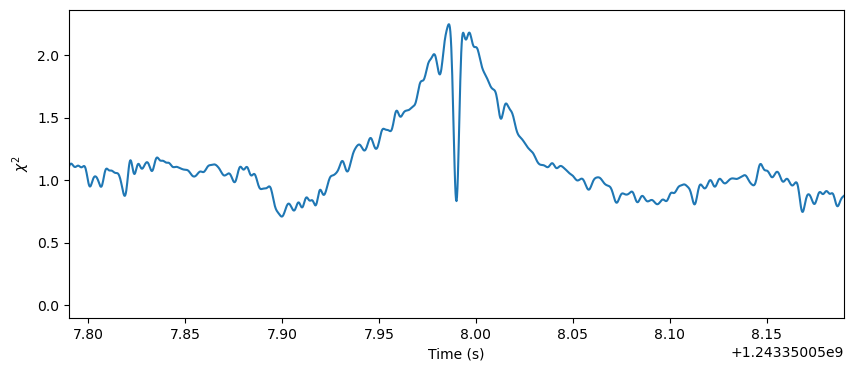

The chisq value associated with our signal is 0.8322126751821445


In [21]:
# we use the 'power_chisq' function in PyCBC - there's no way we're implementing our own!
import pycbc.vetoes
nbins = 20 # this is arbitrary, don't worry too much about this! 
chisq_L1 = pycbc.vetoes.power_chisq(template, L1_timeseries_conditioned_windowed, 
                nbins, 
                estimated_psd_L1,
                low_frequency_cutoff=30,
                return_bins=False)

dof = nbins * 2 - 2
chisq_L1 /= dof

# zoom in close to the merger time! 
plt.figure(figsize=[10, 4])
plt.plot(chisq_L1.sample_times, chisq_L1)
plt.ylabel('$\chi^2$')
plt.xlabel('Time (s)')
plt.xlim(merger_time - .2, merger_time + .2)
plt.show()

# print out the chisq value associated with our signal:
signal_chisq = chisq_L1[np.argmax(np.abs(L1_snr))]
print('The chisq value associated with our signal is {}'.format(signal_chisq))

We would use this value to rank potential signals, or test how well
the template we used to detect the GW matches our signal. A 'perfect fit' will have $\chi^2\simeq1$

If we had a signal that didn't
overlap well with our data, we would get a larger $\chi^2$ value, and deem it less 
significant, and the template would also be deemed a poorer match as the best fitting template maximizes 
the SNR while minimizing the reduced $\chi^2$!

The test allows us to 'rank' potential signals
for their significance in a more fine-grained way than using SNR alone, as it
is able to reject most glitches. However, in our work we will just rely on 
SNR as I promise there are no glitches in this data set!



This is how we would find a signal in one detector data stream.
in reality we have more than one detector data stream to deal with - if we have a real signal, it will be present in both LIGO detectors! 

Caveat: Depending on SNR, what the detector is doing at the time, or in the case of Virgo, sky location, it may be that a signal is not easily detectable in other detectors.

Let's quickly create an SNR timeseries with the Hanford detector. You'll need to make a lot of SNR timeseries
so I suggest consolidating a lot of these processes into one function
that takes in the strain and a few extra numbers, and turns out the SNR timeseries!

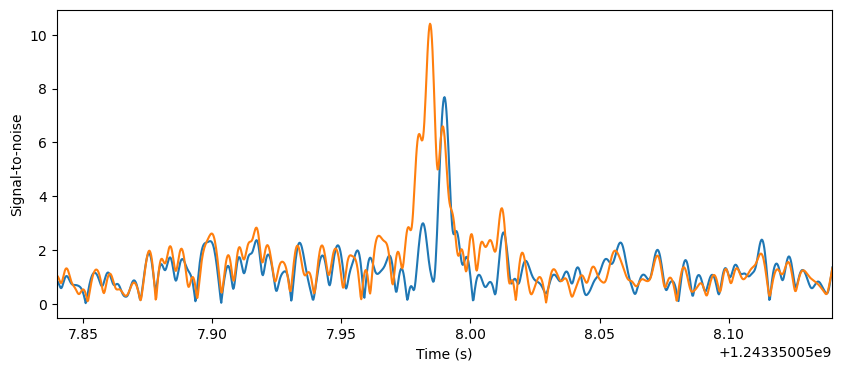

merger time in L1: 1243350057.9899902
merger time in H1: 1243350057.984375


In [23]:
H1_timeseries = load_timeseries(DATA_DIR+'/example_timeseries_H1.txt')
H1_timeseries_conditioned = pycbc.filter.highpass(H1_timeseries, 20.0)
window = tukey(len(H1_timeseries_conditioned), tukey_rolloff / (max(H1_timeseries_conditioned.sample_times) \
                                                                - min(H1_timeseries_conditioned.sample_times)))
H1_timeseries_conditioned_windowed = window * H1_timeseries_conditioned 

estimated_psd_H1 = pycbc.psd.welch(H1_timeseries_conditioned_windowed,
                      seg_len=seg_len,
                      seg_stride=seg_stride)
estimated_psd_H1 = pycbc.psd.interpolate(estimated_psd_H1, H1_timeseries_conditioned_windowed.delta_f)
estimated_psd_H1 = pycbc.psd.inverse_spectrum_truncation(estimated_psd_H1,
                                int(4 * H1_timeseries_conditioned_windowed.sample_rate),
                                  low_frequency_cutoff=20.)


H1_snr = pycbc.filter.matched_filter(template, H1_timeseries_conditioned_windowed,
                     psd=estimated_psd_H1, low_frequency_cutoff=30.0)

# looking at both the timeseries together now!
# zoom in close to the merger time! 
plt.figure(figsize=[10, 4])
plt.plot(L1_snr.sample_times, abs(L1_snr), color = 'tab:blue', label = 'L1')
plt.plot(H1_snr.sample_times, abs(H1_snr), color = 'tab:orange', label = 'H1')
plt.ylabel('Signal-to-noise')
plt.xlabel('Time (s)')
plt.xlim(merger_time - 0.15, merger_time + 0.15)
plt.show()

# print the merger time in each detector:
print('merger time in L1: {}'.format(L1_snr.sample_times[np.argmax(np.abs(L1_snr))]))
print('merger time in H1: {}'.format(H1_snr.sample_times[np.argmax(np.abs(H1_snr))]))

Looking at the data and trying to spot the same signal in two SNR timeseries is all well and good, 
but we need to potentially find the best fitting template out of many, which could take us a long time.

Typically, once the SNR timeseries are generated, some kind of search algorithm is used to find 
potential signals that are present in both detectors (coincident) at times that are consistent with 
the light travel time between detectors. 


For example, here we see that the loudest peak we have is in 
Hanford - we can use this as a starting point to 'blindly' search for a coincident signal in another detector

In [24]:
# calculate the SNR for our loudest signal - the one in H1:
H1_max_snr = max(np.abs(H1_snr))

print('H1 peak has value {}'.format(H1_max_snr))

# calculate our 'on-source window' associated with this peak. The 'on-source window' is all the times that 
# any peak in our second detector could be consistent with an astrophysical signal moving at the speed of light

# PyCBC again has a handy built-in way of doing this! But you can do it by hand (sanity check - the light
# travel time from L1 to H1 is about 10ms, and about 30ms for either American detector to Virgo)
H1_detector = pycbc.detector.Detector("H1")
tof = H1_detector.light_travel_time_to_detector(pycbc.detector.Detector("L1"))

print('Light travel time between detectors is {}'.format(tof))

# now we can find the maximum peak in L1 in this window: 
H1_peak_time = H1_snr.sample_times[np.argmax(np.abs(H1_snr))]

# in principle we do not know if the GW arrived at Hanford first or second:
onsource_start_time = H1_peak_time - tof
onsource_end_time = H1_peak_time + tof 

# we need to do this in terms of samples/index notation
onsource_windowsize_samples = int((onsource_end_time - onsource_start_time) * L1_snr.sample_rate)
start_idx = int((onsource_start_time - L1_snr.start_time) * L1_snr.sample_rate)
end_idx = start_idx + onsource_windowsize_samples

# now we can calculate our 'on-source' SNR for the L1 detector: the largest peak in our on-source window:
L1_max_snr = max(np.abs(L1_snr))

print('The associated L1 on-source peak has SNR {}'.format(L1_max_snr))

# in a real search, for each template you use you would complete this procedure and save your coincident triggers
# Then you would keep the one that most resembled a signal: i.e. the SNR was maximized, and the chisq minimized

# we tend to introduce a new statistic - combined SNR - that accounts for the SNR contributed by both detectors. 
# this is just the quadrature sum of the SNRs:
combined_snr = np.sqrt(L1_max_snr**2 + H1_max_snr**2)
print('the combined SNR of this signal is {}'.format(combined_snr))

# usually to save some time, we only consider 'loud' triggers to find 
# companions to as having an SNR above a certain cut-off. A typical
# choice is around SNR ~ 4

H1 peak has value 10.414662589521217
Light travel time between detectors is 0.010012846152223925
The associated L1 on-source peak has SNR 7.68430199205705
the combined SNR of this signal is 12.942708138512


So there we have it! Now you're ready to go forth and discover. Your challenge:
- Identify as many signals that occur in the LIGO data streams as possible in the data you've been given 
- Get as close as you can to the true chirp mass of those signals, and their merger time, using a template bank search
- Your algorithm's run time should be as short as possible - you should design your algorithm or script so it executes with the press of one button. It should read in your data, filter it, and identify all the signals, with minimal to no intervention.

To help you test your algorithm and how your template bank is working, I have given you two example data streams:
- One contains a signal with high SNR
- One contains a signal with much lower SNR
- Try and recover the best SNR you possibly can to figure out what the chirp mass and coalescense time is!

Some hints about the challenge data:
- I have only hidden BBH signals in the data
- No signals overlap
- Not all (or maybe not any) will have exactly equal masses
- The mass distribution I have drawn them from is uniform, with 25 < mass < 100 for each component
- No nasty tricks: there are no eccentric signals, things with weird spins etc. These are all vanilla BBHs. They have random z-axis spin, and no x or y spin component

# Extension challenge notes: estimating significance for very faint signals, or signals in noisy data

So far you've seen signals in Gaussian data that is very clear of 'glitches' - regions where the data violates 
all our assumptions that the data is stationary and Gaussian - and signals that are quite loud and obviously stand 
out from the noise floor. However what if you had either a very faint signal, or our noise floor was higher? We may want to calculate how likely it is that a signal seen in the second (or third) detector is astrophysical. 